# Non-Unitary Operators for the Non-Hermitian Skin Effect

Paper to be replicated: https://arxiv.org/pdf/2311.10143

Addition Resources Consulted:
- https://link.aps.org/pdf/10.1103/PRXQuantum.2.010342
- https://medium.com/mdr-inc/time-evolution-operators-be2968493b86 (note there are some notable errors)
- 

In [143]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import UnitaryGate

from tqdm.notebook import tqdm

from numpy import sin, cos
import numpy as np
from scipy.linalg import expm, sqrtm

from itertools import product

import random

import json



In [144]:
# service = QiskitRuntimeService()
BACKEND = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=BACKEND, optimization_level=0)
estimator = Estimator(backend=BACKEND)
sampler = Sampler(backend=BACKEND)

In [ ]:
%set_env QXToken=a7fcc7473249a012e25a2fcd2d707e1bad0147347980ee262685115c42e30b7410dbc887e039a23266c21997a4accb5f3b8669d952a2a75d4d80d0c360d130a0


## I. Hatano-Nelson Model

Note $\hat{X}^+ = \frac{\hat{X} + i \hat{Y}}{2}$ and $\hat{X}^- = \frac{\hat{X} - i \hat{Y}}{2}$

In [281]:
X_gate = np.array([[0, 1], 
                   [1, 0]])

Y_gate = np.array([[0, -1j],
                   [1j, 0]])

I_gate = np.array([[1, 0], 
                   [0, 1]])

X_plus = 0.5 * (X_gate + 1j * Y_gate)
X_minus = 0.5 * (X_gate - 1j * Y_gate)

In [249]:
print(X_minus)

#X_plus = np.array([[1, 0], 
#                   [0, 0]])

#X_minus = np.array([[0, 0], 
#                   [0, 1]])

[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]]


In [282]:
def get_U_j_nonH(J, gamma, index, N, timestep):
    product_1 = np.kron(X_plus, X_minus)
    product_2 = np.kron(X_minus, X_plus)
    exponent = 1j * timestep * ( (J - gamma) * product_1 + (J + gamma) * product_2)
    if index == 0:
        U_j_nonH = np.kron(expm(exponent), np.eye(index ** (N-2)))
    if index == N - 2:
        U_j_nonH = np.kron(np.eye(2 ** (N-2)), expm(exponent))
    else: 
        U_j_nonH = np.kron(np.kron(np.eye(2 ** (index)), expm(exponent)), np.eye(2 ** (N - 2 - index)))
    return U_j_nonH


def get_R_HN(J, gamma, N, timestep):
    res_even = np.eye(2 ** N)
    res_odd = np.eye(2 ** N)
    for i in range(N - 1):
        if i % 2 == 0:
            res_even = np.matmul(res_even, get_U_j_nonH(J, gamma, i, N, timestep))
        else:
            res_odd = np.matmul(res_odd, get_U_j_nonH(J, gamma, i, N, timestep))
    return np.matmul(res_even, res_odd)


def get_U_HN(J, gamma, N, timestep):
    R_HN = get_R_HN(J, gamma, N, timestep)

    A, sig, Bh = np.linalg.svd(R_HN)
    eigval, _ = np.linalg.eig(np.matmul(R_HN.conj().T, R_HN))
    u_square_inverse = max(eigval)
    u_square = 1/u_square_inverse 
    C = np.matmul(np.matmul(A, sqrtm(np.eye(2 ** N) - u_square * np.diag(np.square(sig)))), Bh)

    u_R_HN = np.sqrt(u_square) * R_HN
    W = np.concatenate((np.concatenate((u_R_HN, C), axis=0), np.concatenate((np.eye(2 ** N), np.eye(2 ** N)), axis=0)), axis=1)
    U_HN, _ = np.linalg.qr(W)
    return U_HN

In [283]:
def magnetization_ops(qubit, N):
    observable = SparsePauliOp.from_sparse_list(
    [("Z", [qubit], 0.5), ("I", [qubit], 0.5)], num_qubits=N
    )
    return observable

In [284]:
total_time = 1.8
nb_timesteps = 10
timestep_duration = total_time/nb_timesteps

In [287]:
N = 6

matrix = get_U_HN(1, 0, N, timestep_duration)
gate = UnitaryGate(matrix)

circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1,N+1)
    qc.h(N//2 - 1)
    qc.cx(N//2 -1, N//2)
    qc.x(range(N))
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N+1)])
    

    circuits.append(pass_manager.run(qc))

magnetization=[]
for circ in tqdm(circuits):
    pubs = [(circ, magnetization_ops(qubit, N+1)) for qubit in range(N)]
    job = estimator.run(pubs)
    results = job.result()

    magnetization.append([results[i].data.evs for i in range(N)])

magnetization=np.array(magnetization)



  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'T')

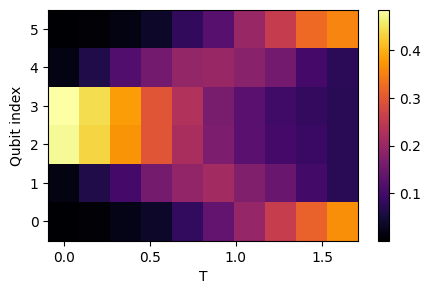

In [288]:
fig = plt.figure(figsize=(10/2,6/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

In [289]:
N = 6

matrix = get_U_HN(1, 0.3, N, timestep_duration)
gate = UnitaryGate(matrix)

circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    qc.h(N//2 - 1)
    qc.cx(N//2 -1, N//2)
    qc.x(range(N))
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N+1)])
    
    qc.measure_all()
    circuits.append(qc)
    #circuits.append(pass_manager.run(qc))

magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '0':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #due to qiskit's big endian

magnetization=np.array(magnetization)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print(magnetization)

Text(0.5, 0, 'T')

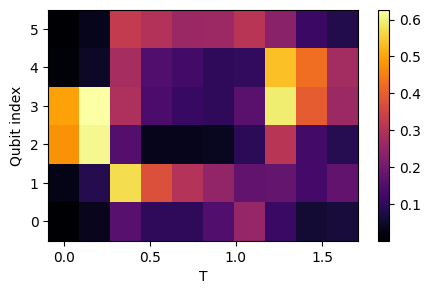

In [290]:
fig = plt.figure(figsize=(10/2,6/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

In [299]:
matrix = get_U_HN(1, 0, 2, timestep_duration)
print(matrix[4:, 0:4])

[[-0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j]]
